In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import earthpy as et
import xarray as xr
import regionmask

import warnings
warnings.filterwarnings("ignore")

#### The goal of this code is to crop the national gridded smoke PM2.5 product from O'Dell et al. (2019) to the state of New Mexico in order to take an average just for the state

 ##### code adapted from: https://www.earthdatascience.org/courses/use-data-open-source-python/hierarchical-data-formats-hdf/subset-netcdf4-climate-data-spatially-aoi/

In [3]:
# Download natural earth data which contains state boundaries to generate AOI
url =  (
    "https://naturalearth.s3.amazonaws.com/"
    "50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip"
)
states_gdf = gpd.read_file(url)
# Use the bounds to determine the slice values for this data
# We select New Mexico, but this code can work for any US state
newmexico_aoi = states_gdf[states_gdf.name == "New Mexico"]

In [4]:
# Open gridded smoke dataset for 2022 (2021 and older have a different set up)
df = xr.open_dataset('C:/Users/olivia.sablan/OneDrive - State of New Mexico/Documents/Data/smoke/KateGridded/NM_griddedPM_all-final_2022.nc')

#The format is not suitable for this analysis so the following takes the smoke pm2.5 and makes a new dataset
lat = np.zeros((71))
lon = np.zeros((71))
smoke_vals = df['smokepm'].values
time = np.arange(1,366)

# Need to loop through to not get repeated values of lats/lons
for i in range(71):
    lat[i] = df['lat'][i][0]
    lon[i] = df['lon'][0][i]

#put all the variables I listed above into a new xarray
new_df_xr = xr.DataArray(smoke_vals, coords= {'time': time, 'lat':lat, 'lon': lon}, dims = ['time', 'lat', 'lon'])

# Make a mask of just the state of interest
nm_mask = regionmask.mask_3D_geopandas(newmexico_aoi, new_df_xr.lon, new_df_xr.lat)
# Apply the mask to the new dataset
nm_grid = new_df_xr.where(nm_mask)
# Take the mean of the time dimension to get annual smoke
nm_mean = nm_grid.mean(dim = 'time')

print('2022 annual smoke mean:', np.mean(nm_grid).values.round(1), 'STD: ', np.std(nm_grid).values.round(1))

total_vals = df['totalpm'].values
new_df_xr = xr.DataArray(total_vals, coords= {'time': time, 'lat':lat, 'lon': lon}, dims = ['time', 'lat', 'lon'])
nm_mask = regionmask.mask_3D_geopandas(newmexico_aoi, new_df_xr.lon, new_df_xr.lat)
nm_grid = new_df_xr.where(nm_mask)
nm_mean = nm_grid.mean(dim = 'time')
print('2022 annual total mean:', np.mean(nm_grid).values.round(1), 'STD: ', np.std(nm_grid).values.round(1))


2022 annual smoke mean: 0.6 STD:  2.0
2022 annual total mean: 5.4 STD:  3.2


In [5]:
# Repeat this process for the other years of data
listofDF = ['../Data/smoke/KateGridded/krigedPM25_2021_4repo.nc', '../Data/smoke/KateGridded/krigedPM25_2020_4repo.nc', '../Data/smoke/KateGridded/krigedPM25_2019_4repo.nc', '../Data/smoke/KateGridded/krigedPM25_2018_v2.nc',
            '../Data/smoke/KateGridded/krigedPM25_2017_v2.nc', '../Data/smoke/KateGridded/krigedPM25_2016_v2.nc']
listofYears = ['2021', '2020', '2019', '2018', '2017', '2016']

In [6]:
# Loop through the other gridded years and print the NM average smoke PM2.5
for i in range(0,6):
    print(listofYears[i])
    df = xr.open_dataset(listofDF[i])
    lat = np.zeros(189)
    for i in range(189):
        lat[i] = df['lat'][i][0]
    lon = np.zeros(309)
    for i in range(309):
        lon[i] = df['lon'][0][i]
    total_vals = df['PM25'].values
    time = np.arange(1,len(df['date'])+1)
    new_df_xr = xr.DataArray(total_vals, coords= {'time': time, 'lat':np.unique(lat), 'lon': np.unique(lon)}, dims = ['time', 'lat', 'lon'])
    nm_mask = regionmask.mask_3D_geopandas(newmexico_aoi,new_df_xr.lon, new_df_xr.lat)
    nm_grid = new_df_xr.where(nm_mask)
    print('Annual total mean:', np.mean(nm_grid).values.round(1), 'STD: ', np.std(nm_grid).values.round(1))
    df['smokepm25'] = df['PM25'] - df['Background_PM25']
    smokevals = df['smokepm25'].values
    new_df_xr = xr.DataArray(smokevals, coords= {'time': time, 'lat':np.unique(lat), 'lon': np.unique(lon)}, dims = ['time', 'lat', 'lon'])
    nm_mask = regionmask.mask_3D_geopandas(newmexico_aoi,new_df_xr.lon, new_df_xr.lat)
    nm_grid = new_df_xr.where(nm_mask)
    print('Annual smoke mean:', np.mean(nm_grid).values.round(1), 'STD: ', np.std(nm_grid).values.round(1))



2021
Annual total mean: 6.3 STD:  4.9
Annual smoke mean: 1.4 STD:  4.5
2020
Annual total mean: 6.2 STD:  4.1
Annual smoke mean: 1.2 STD:  3.8
2019
Annual total mean: 4.5 STD:  2.5
Annual smoke mean: 0.3 STD:  2.2
2018
Annual total mean: 5.7 STD:  5.3
Annual smoke mean: 1.3 STD:  5.2
2017
Annual total mean: 4.9 STD:  3.0
Annual smoke mean: 0.6 STD:  2.8
2016
Annual total mean: 4.7 STD:  2.8
Annual smoke mean: 0.3 STD:  2.5


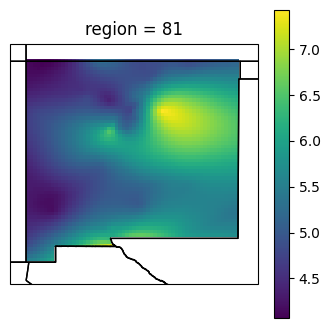

In [7]:
# Plot the cropped gridded smoke to demonstrate the we have successfully cropped the national grid to the state of New Mexico
fig = plt.figure(figsize=(4,4))
map_bounds = [-109.5, -102.5, 30.7, 37.5]
ax = plt.axes(projection = ccrs.PlateCarree())
ax.set_extent(map_bounds, ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, color = 'k')
ax.add_feature(cfeature.STATES, zorder = 10)
nm_mean.plot(ax = ax)